<a href="https://colab.research.google.com/github/max1nehour/pm25_lstm/blob/main/One_20_LSTM_daily_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [319]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [320]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import matplotlib.dates as mdates
import pandas as pd
from glob import glob

#列出檔名開頭pm25的檔案
df_train = pd.read_csv('drive/MyDrive/pm25/pm2.5_data_3.csv',dtype={ 'Date': str, 'area':str})
print(df_train)

dataset_test = glob('drive/MyDrive/pm25/2020test.csv')
print(dataset_test)

#以列合併train data 僅讀取'Date','area','PM2_5_avg' 設定欄位資料型態'Date': str, 'area':str

df_test = pd.concat(
    (pd.read_csv(file, usecols=['date','area','pm25'], dtype={ 'Date': str, 'area':str}) for file in dataset_test ), ignore_index=True)

#replace 'x' by 'nan'
df_test['pm25'] = df_test['pm25'].replace('x','NaN')
#datatype transform
df_test['pm25'] = df_test['pm25'].astype(float)
print(df_test)

max_pm25 = df_test['pm25'].max(axis=0)
min_pm25 = df_test['pm25'].min(axis=0)
print(max_pm25)
print(min_pm25)

            Date       area  Long_range_trans  Vehicle_exhaust  Coal_fired  \
0     2017-01-01    Banqiao          0.456520         4.401043    0.502707   
1     2017-01-01     Chiayi          0.387843        22.131700    0.773481   
2     2017-01-01     Douliu          1.657679        11.170355    1.552080   
3     2017-01-01    Hualien          0.034066         3.683370    0.094480   
4     2017-01-01   Xiaogang          2.605544        19.554745    1.393970   
...          ...        ...               ...              ...         ...   
1092  2019-12-23     Chiayi          0.381544        15.153218    0.575682   
1093  2019-12-23     Douliu          0.520352         8.169237    2.453606   
1094  2019-12-23    Hualien          0.071570         2.015280    0.121488   
1095  2019-12-23   Xiaogang          2.663056         9.696881    0.401567   
1096  2019-12-23  Zhongming          0.164308         3.985862    3.010674   

      Road_dust  Soil_dust  Industrial_processes  Agricultural_

In [321]:
# Import the training set 2019以前
site = 'Xiaogang'
filt = (df_train['area'] == site)
training_set = df_train.loc[filt, ['PM2_5']].values
#print(training_set, '\n\n')
print(training_set.shape) #183
# test set
site2 = '小港'
filt2 = (df_test['area'] == site2)
test_set = df_test.loc[filt2, ['pm25']].values
#print(test_set)
print(test_set.shape) #360

(183, 1)
(364, 1)


做 Normalization，將資料壓縮在 [0,1] 之間

In [322]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1)) #控制最大值最小值範圍
training_set_scaled = sc.fit_transform(training_set)#fit_transform: 先對partData作fit()的功能，找到該partData的整體統計特性之指標，如平均值、標準差、最大最小值等等(能依據不同目的套用這些指標在不同的轉換(即後面的transform()動作)上，再實行transform(partData)以對partData進行標準化
print(training_set_scaled.shape)
#training_set_scaled = training_set

(183, 1)


準備進入訓練的資料格式：設定 Timestep 設為 60 ，代表過去 60 天的資訊，嘗試過數值設置太少，將使 RNN 無法學習。

In [323]:
X_train = []
y_train = []
for i in range(1, 182):  # 訓練集總數
    X_train.append(training_set_scaled[i-1:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

Reshape
因為現在 X_train 是 2-dimension，將它 reshape 成 3-dimension: [stock prices, timesteps, indicators]

In [324]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#搭建一個 LSTM

In [325]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

搭建 LSTM layer

units: 神經元的數目

第一層的 LSTM Layer 記得要設定input_shape參數

搭配使用dropout，這裡設為 0.2

由於這邊的第四層 LSTM Layer 即將跟 Ouput Layer 做連接，因此注意這邊的 return_sequences 設為預設值 False （也就是不用寫上 return_sequences）

In [326]:
from keras.layers import Bidirectional

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [327]:
# Adding the output layer
regressor.add(Dense(units = 1))

#Compiling & Fitting LSTM model

optimizer: 選擇 Adam

loss: 使用 MSE

In [328]:
# Compiling
import tensorflow as tf
from keras import optimizers
from keras import metrics
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[metrics.mae, metrics.sparse_top_k_categorical_accuracy]) #adam is good at time series data
print(X_train.shape)
# 進行訓練
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)
# val_loss 驗證集損失: 比訓練集損失小，是一個好的表現
# Val_accuracy 驗證集準確率
# val_accuracy 衡量模型在未見過的數據上的預測準確性

(181, 1, 1)
Epoch 1/30
6/6 [==============================] - 8s 17ms/step - loss: 0.1724 - mean_absolute_error: 0.3371 - sparse_top_k_categorical_accuracy: 0.9945
Epoch 2/30
6/6 [==============================] - 0s 16ms/step - loss: 0.1569 - mean_absolute_error: 0.3142 - sparse_top_k_categorical_accuracy: 0.9945
Epoch 3/30
6/6 [==============================] - 0s 16ms/step - loss: 0.1389 - mean_absolute_error: 0.2891 - sparse_top_k_categorical_accuracy: 0.9945
Epoch 4/30
6/6 [==============================] - 0s 15ms/step - loss: 0.1189 - mean_absolute_error: 0.2624 - sparse_top_k_categorical_accuracy: 0.9945
Epoch 5/30
6/6 [==============================] - 0s 15ms/step - loss: 0.0947 - mean_absolute_error: 0.2342 - sparse_top_k_categorical_accuracy: 0.9945
Epoch 6/30
6/6 [==============================] - 0s 14ms/step - loss: 0.0727 - mean_absolute_error: 0.2137 - sparse_top_k_categorical_accuracy: 0.9945
Epoch 7/30
6/6 [==============================] - 0s 14ms/step - loss: 0.056

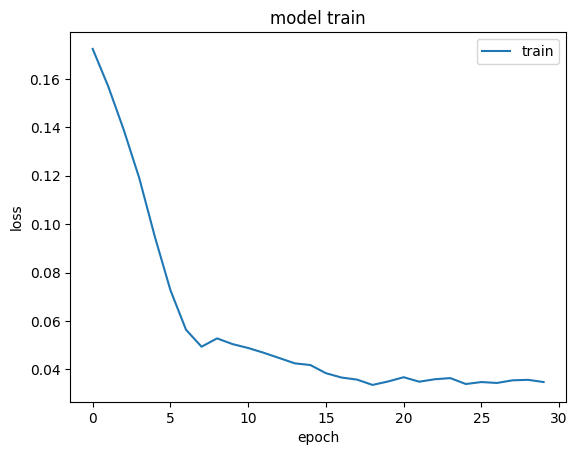

In [329]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model train')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.show()

# 進行預測

In [330]:
#取測試 2020的pm2.5
real_pm25 = test_set
#print(real_pm25.shape) #360
#print(real_pm25)

In [331]:
dataset_total = pd.concat((df_train['PM2_5'], df_test['pm25']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(df_test) - 1:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling
print(inputs.shape)

X_test = []
for i in range(1,361): # timesteps一樣60； 81 = 20+61
    X_test.append(inputs[i- 1:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

(2171, 1)


In [332]:
#進行預測
predicted_pm25 = regressor.predict(X_test)
predicted_pm25 = sc.inverse_transform(predicted_pm25)  # to get the original scale

12/12 [==============================] - 2s 3ms/step


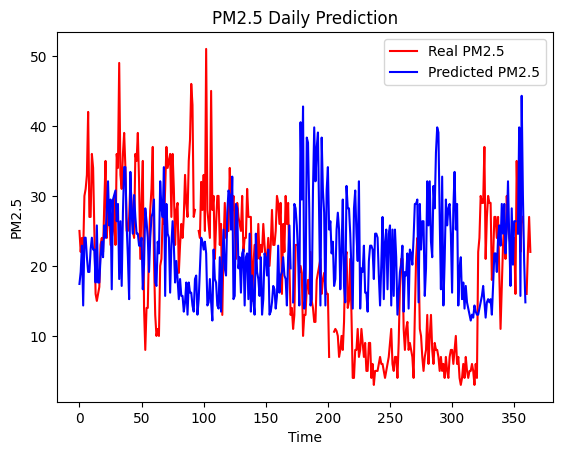

In [333]:
#x = df_test['Date']
plt.plot(real_pm25, color = 'red', label = 'Real PM2.5')  # 紅線表示真實股價
plt.plot(predicted_pm25, color = 'blue', label = 'Predicted PM2.5')  # 藍線表示預測股價
plt.title('PM2.5 Daily Prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


In [334]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(real_pm25.shape)
print(predicted_pm25.shape)

real = pd.DataFrame(real_pm25)
predict = pd.DataFrame(predicted_pm25)

real.fillna(real.mean(), inplace=True)
predict.fillna(predict.mean(), inplace=True)

rmse = np.sqrt(mean_squared_error(real[250:360], predict[250:360]))
mae = mean_absolute_error(real[250:360], predict[250:360])

rmse_175 = np.sqrt(mean_squared_error(real[0:250], predict[0:250]))
mae_175 = mean_absolute_error(real[0:250], predict[0:250])

rmse_230 = np.sqrt(mean_squared_error(real[230:300], predict[230:300]))
mae_230 = mean_absolute_error(real[230:300], predict[230:300])

print("RMSE(230-300):", rmse_230)
print("MAE:", mae_230)
print("------------------")
print("RMSE(250:360):", rmse)
print("MAE:", mae)
print("------------------")
print("RMSE(0:250):", rmse_175)
print("MAE:", mae_175)



(364, 1)
(360, 1)
RMSE(230-300): 16.349088076622724
MAE: 14.781345312935965
------------------
RMSE(250:360): 13.873682074963696
MAE: 11.81802640394731
------------------
RMSE(0:250): 11.697227116968644
MAE: 9.572331669586779
